In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Enable quiet mode to hide verbose output
!pip install -q nilearn

# Ensure a stable PyTorch version
!pip install torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install compatible PyG wheels for torch 2.5.1 + cu121
!pip install torch-scatter==2.1.2 -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install torch-geometric==2.6.1

# Check installations
import torch, nilearn
import torch_geometric
print("Torch:", torch.__version__)
print("Nilearn:", nilearn.__version__)
print("PyG:", torch_geometric.__version__)

Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Torch: 2.5.1+cu121
Nilearn: 0.12.1
PyG: 2.6.1


In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool, GATConv
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from nilearn.plotting import plot_connectome, plot_matrix, show
from sklearn.decomposition import PCA
import math

In [4]:
corr_dir = '/content/drive/Shareddrives/291A_Brain_Connectomes/FullCorrelationSubjects'

subject_ids = [
  os.path.splitext(f)[0]
  for f in os.listdir(corr_dir)
  if f.endswith(".csv")
]

In [5]:
phen_df = pd.read_csv('/content/drive/Shareddrives/291A_Brain_Connectomes/AABC_Release1_Non-imaging_Data-XL.csv', usecols=[0, 7, 381, 475, 2343], header=1) # 0 - subject_id, 7 - age, 381 - moca_sum, 476 - ravlt_learning_score
phen_df.head()

id_event age_open  moca_sum  ravlt_learning_score  psqi_global
0  HCA6000030_V1       86      22.0                   1.0          5.0
1  HCA6002236_V1       46      25.0                   7.0          6.0
2  HCA6002236_F1       47       NaN                   NaN          NaN
3  HCA6002236_V2       48      27.0                   9.0          2.0
4  HCA6002236_F2       49       NaN                   NaN          NaN

In [6]:
def pack_upper_triangular(mat, N=379):
  triu_idx = torch.triu_indices(N, N, offset=1)
  return mat[triu_idx[0], triu_idx[1]]

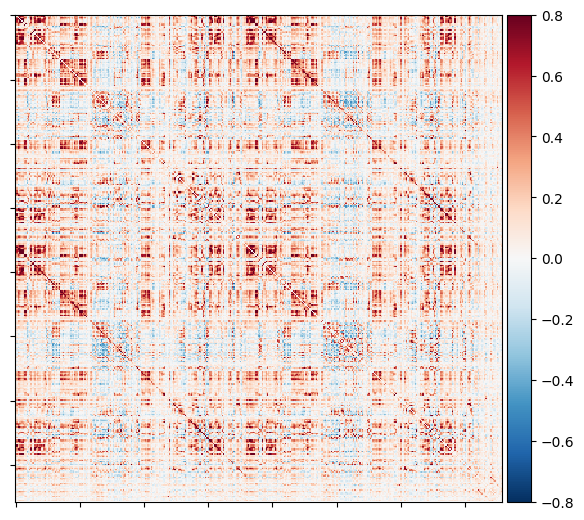

In [7]:
test_subject = subject_ids[0]
fullcorr = pd.read_csv(os.path.join(corr_dir, f"{test_subject}.csv"))
fullcorr = np.array(fullcorr.drop(fullcorr.columns[0], axis=1).select_dtypes(include="number"))
plot_matrix(fullcorr, vmin=-0.8, vmax=0.8)
show()

In [8]:
phen = phen_df.set_index('id_event')

dataset = []
count = 0

for si in subject_ids:
  row_vals = phen.loc[si]
  if row_vals.notna().all():
    filename = f"{si}.csv"
    A = pd.read_csv(os.path.join(corr_dir, filename))
    A_t = torch.from_numpy(np.array(A.drop(A.columns[0], axis=1).select_dtypes(include="number")))


    edge_index=torch.nonzero(A_t != 0, as_tuple=False).t().contiguous()
    edge_attr = A_t[edge_index[0], edge_index[1]].clone()

    data = Data(
        x=A_t,
        edge_index=edge_index,
        edge_attr=edge_attr,
        age=torch.tensor(int(row_vals['age_open'].split()[0])),
        moca=torch.tensor(row_vals['moca_sum']),
        ravlt=torch.tensor(row_vals['ravlt_learning_score']),
        psqi=torch.tensor(row_vals['psqi_global']),
        subject_id=si
    )
    dataset.append(data)
    count += 1
    if(count == 500): break

print(len(dataset))

500


In [9]:
print(dataset[0])

Data(x=[379, 379], edge_index=[2, 143262], edge_attr=[143262], age=38, moca=26.0, ravlt=2.0, psqi=4.0, subject_id='HCA8244674_V1')


In [ ]:
class GATVAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim, num_heads=4):
    super(GATVAE, self).__init__()
    self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True, dropout=0.5, add_self_loops=False)
    self.gat2 = GATConv(hidden_dim*num_heads, hidden_dim, heads=1, concat=True, dropout=0.5, add_self_loops=False)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    self.fc3 = nn.Linear(latent_dim, hidden_dim*2)
    self.fc4 = nn.Linear(hidden_dim*2, input_dim*input_dim)

  def encode(self, x, edge_index, batch):
    x = F.relu(self.gat1(x, edge_index))
    x = F.relu(self.gat2(x, edge_index))
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    return mu + torch.exp(0.5*logvar)*torch.randn_like(torch.exp(0.5*logvar))

  def decode(self, z, batch):
    h3 = torch.relu(self.fc3(z))
    # return self.fc4(h3).view(-1, input_dim, input_dim)
    return torch.tanh(self.fc4(h3).view(-1, input_dim, input_dim))

  def forward(self, data):
    mu, logvar = self.encode(data.x, data.edge_index, data.batch)
    node_z = self.reparameterize(mu, logvar)
    z = global_mean_pool(node_z, data.batch)
    return self.decode(z, data.batch), mu, logvar

def loss_function(recon_x, x, mu, logvar):
  # fro = torch.norm(recon_x - x, p='fro') # Frobenius Norm
  mse = torch.mean((recon_x - x) ** 2)
  # l1 = torch.mean(torch.abs(recon_x - x))
  KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return mse + KL

def train_model(model, dataloader, optimizer, num_epochs=50, device='cpu'):
  model.to(device)
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
      batch_data = batch.to(device)
      batch_data.x = batch_data.x.float()
      optimizer.zero_grad()
      recon_x, mu, logvar = model(batch_data)
      loss = loss_function(recon_x.view(-1, recon_x.size(-1)), batch_data.x, mu, logvar)
      total_loss += loss.item()
      loss.backward()
      optimizer.step()
      torch.cuda.empty_cache()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

  return model

input_dim = 379
hidden_dim = 256
latent_dim = 32

gatvae = GATVAE(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(gatvae.parameters(), lr=1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader = DataLoader(dataset, batch_size=4)
trained_model = train_model(gatvae, train_loader, optimizer, num_epochs=50, device=device)

Epoch [1/50], Loss: 475.8743
Epoch [2/50], Loss: 20.2927
Epoch [3/50], Loss: 9.8351
Epoch [4/50], Loss: 7.1801
Epoch [5/50], Loss: 5.7189
Epoch [6/50], Loss: 4.8357
Epoch [7/50], Loss: 4.2104
Epoch [8/50], Loss: 3.7777
Epoch [9/50], Loss: 3.4577
Epoch [10/50], Loss: 3.2428
Epoch [11/50], Loss: 3.0478
Epoch [12/50], Loss: 2.8983
Epoch [13/50], Loss: 2.8159
Epoch [14/50], Loss: 2.6886
Epoch [15/50], Loss: 2.6107
Epoch [16/50], Loss: 2.5202
Epoch [17/50], Loss: 2.4571
Epoch [18/50], Loss: 2.3927
Epoch [19/50], Loss: 2.3264
Epoch [20/50], Loss: 2.3145
Epoch [21/50], Loss: 2.2160
Epoch [22/50], Loss: 2.1531
Epoch [23/50], Loss: 2.1205
Epoch [24/50], Loss: 2.0624
Epoch [25/50], Loss: 2.0202
Epoch [26/50], Loss: 1.9919
Epoch [27/50], Loss: 1.9952
Epoch [28/50], Loss: 1.9481
Epoch [29/50], Loss: 1.8988
Epoch [30/50], Loss: 1.8860
Epoch [31/50], Loss: 1.8668
Epoch [32/50], Loss: 1.8399
Epoch [33/50], Loss: 1.8210
Epoch [34/50], Loss: 1.8182
Epoch [35/50], Loss: 1.8029
Epoch [36/50], Loss: 1.807

In [ ]:
gatvae.eval()

GATVAE(
  (gat1): GATConv(379, 256, heads=4)
  (gat2): GATConv(1024, 256, heads=1)
  (fc_mu): Linear(in_features=256, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=143641, bias=True)
)

In [10]:
def sample_latent(latent_dim):
  return torch.randn(1, latent_dim)

def generate_graph(model, latent_dim, device='cpu'):
  model.eval()
  z = sample_latent(latent_dim).to(device)
  z = z.detach()

  with torch.no_grad():
    new_node_features = model.decode(z, batch=None)

  new_node_features = new_node_features.detach().view(379, -1)

  return new_node_features.cpu().numpy()

def generate_multiple_graphs(model, num_graphs, latent_dim, device='cpu'):
  generated_graphs = []
  for _ in range(num_graphs):
    adj_matrix = generate_graph(model, latent_dim, device)
    generated_graphs.append(adj_matrix)
  return generated_graphs

def plot_multiple_graphs(graphs):
  for i, adj_matrix in enumerate(graphs):
    plot_matrix(adj_matrix, vmin=-0.8, vmax=0.8)
    plt.show()

Generated Adjacency Matrix:


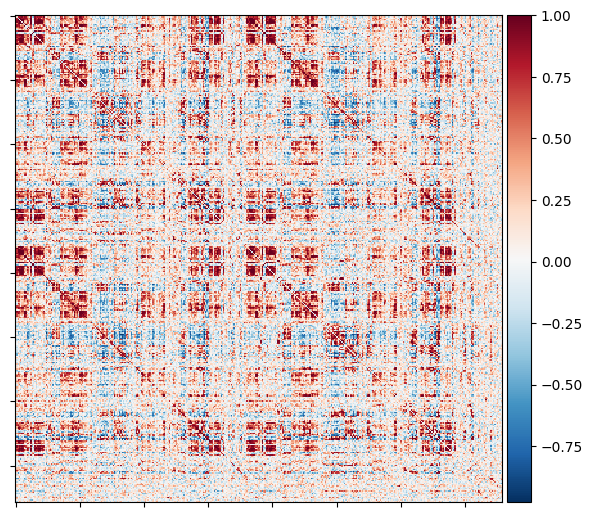

In [ ]:
graph = generate_graph(gatvae, 32, device=device)
print("Generated Adjacency Matrix:")

plot_matrix(graph)
show()

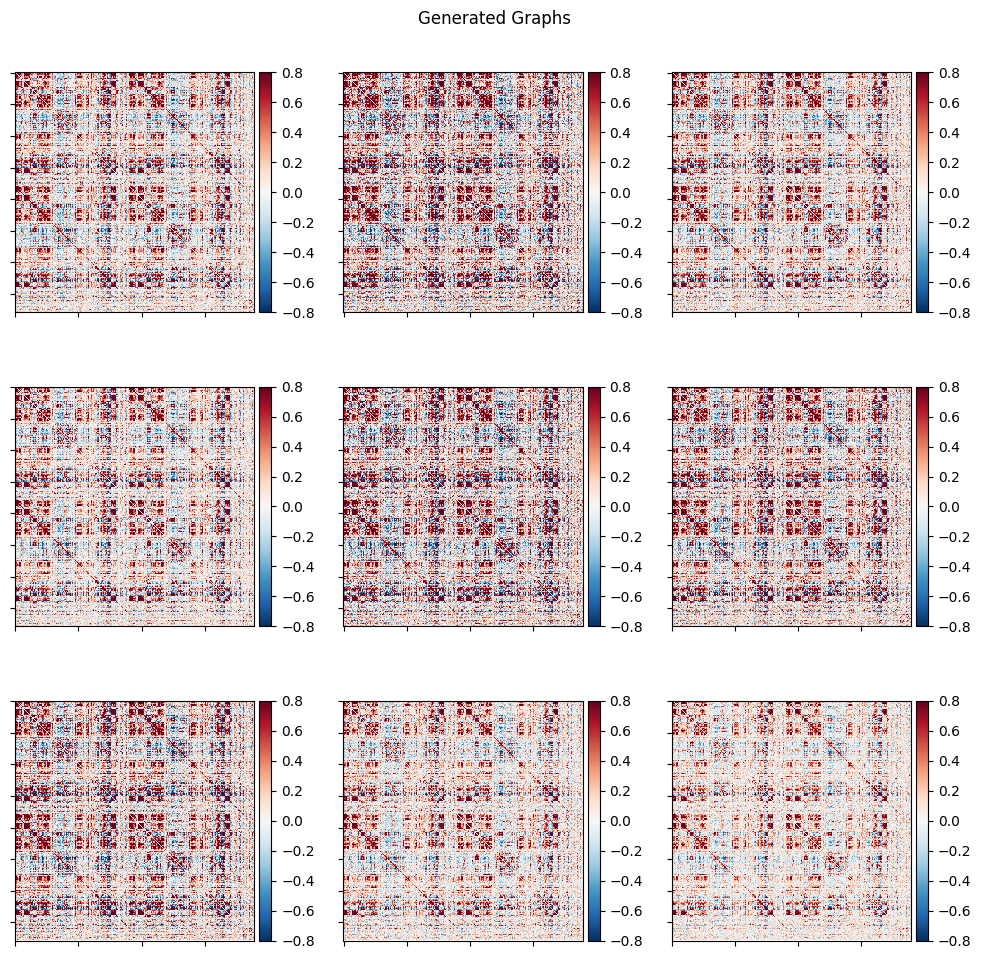

In [ ]:
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()
graphs = generate_multiple_graphs(trained_model, n_rows*n_cols, 32, device=device)

for i in range(n_rows*n_cols):
  ax = axes[i]
  plot_matrix(graphs[i], colorbar=True, vmin=-0.8, vmax=0.8, axes=ax)

plt.suptitle("Generated Graphs")
plt.tight_layout()
plt.show()

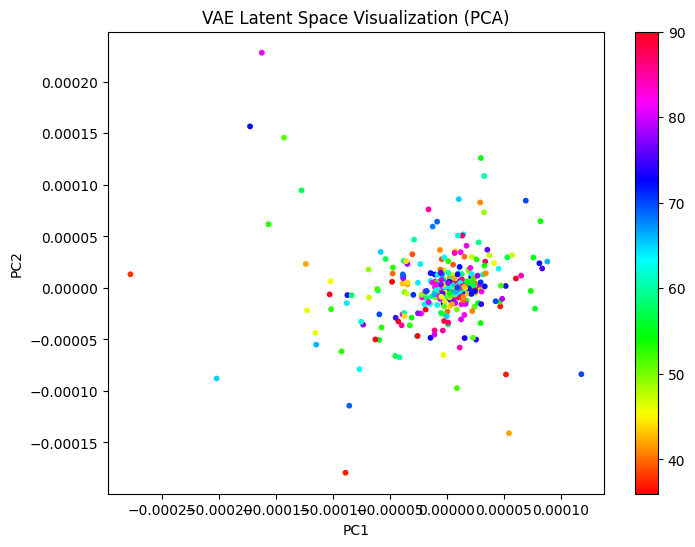

In [ ]:
trained_model.eval()
all_mu = []
all_labels = []

with torch.no_grad():
  for batch in train_loader:
    batch = batch.to(device='cuda' if torch.cuda.is_available() else 'cpu')
    batch.x = batch.x.float()
    mu, _ = trained_model.encode(batch.x, batch.edge_index, batch.batch)
    graph_mu = global_mean_pool(mu, batch.batch)
    all_mu.append(graph_mu.cpu())
    labels = batch.age.cpu()
    all_labels.append(labels)

latent = torch.cat(all_mu, dim=0)
all_labels = torch.cat(all_labels, 0)
latent_2d = PCA(n_components=2).fit_transform(latent.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=all_labels, cmap='hsv', s=10)
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("VAE Latent Space Visualization (PCA)")
plt.show()

In [11]:
class GATVAE2(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim, num_heads=4):
    super(GATVAE2, self).__init__()
    self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True, dropout=0.5, add_self_loops=False)
    self.gat2 = GATConv(hidden_dim*num_heads, hidden_dim, heads=1, concat=True, dropout=0.5, add_self_loops=False)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    self.fc3 = nn.Linear(latent_dim, hidden_dim*2)
    self.fc4 = nn.Linear(hidden_dim*2, input_dim*input_dim)

  def encode(self, x, edge_index, batch):
    x = F.relu(self.gat1(x, edge_index))
    x = F.relu(self.gat2(x, edge_index))
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    return mu + torch.exp(0.5*logvar)*torch.randn_like(torch.exp(0.5*logvar))

  def decode(self, z, batch):
    h3 = torch.relu(self.fc3(z))
    # return self.fc4(h3).view(-1, input_dim, input_dim)
    return torch.tanh(self.fc4(h3).view(-1, input_dim, input_dim))

  def forward(self, data):
    mu, logvar = self.encode(data.x, data.edge_index, data.batch)
    node_z = self.reparameterize(mu, logvar)
    z = global_mean_pool(node_z, data.batch)
    return self.decode(z, data.batch), mu, logvar

def loss_function(recon_x, x, mu, logvar):
  # fro = torch.norm(recon_x - x, p='fro') # Frobenius Norm
  mse = F.mse_loss(recon_x, x, reduction="mean")
  # l1 = torch.mean(torch.abs(recon_x - x))
  KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return mse + KL, mse, KL

def train_model(model, dataloader, optimizer, num_epochs=50, device='cpu'):
  model.to(device)
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    for batch in dataloader:
      batch_data = batch.to(device)
      batch_data.x = batch_data.x.float()
      optimizer.zero_grad()
      recon_x, mu, logvar = model(batch_data)
      loss, recon, kl = loss_function(recon_x.view(-1, recon_x.size(-1)), batch_data.x, mu, logvar)
      total_loss += loss.item()
      total_recon += recon.item()
      total_kl += kl.item()
      loss.backward()
      optimizer.step()
      del batch_data
      del recon_x
      del mu
      del logvar
      torch.cuda.empty_cache()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Recon Loss: {total_recon:.4f}, KL Loss: {total_kl:.4f}")

  return model

input_dim = 379
hidden_dim = 256
latent_dim = 8

gatvae2 = GATVAE2(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(gatvae2.parameters(), lr=1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader = DataLoader(dataset, batch_size=4)
gatvae2 = train_model(gatvae2, train_loader, optimizer, num_epochs=40, device=device)

Epoch [1/40], Loss: 129.9635, Recon Loss: 1.8426, KL Loss: 128.1209
Epoch [2/40], Loss: 6.7724, Recon Loss: 1.7138, KL Loss: 5.0586
Epoch [3/40], Loss: 3.7530, Recon Loss: 1.6910, KL Loss: 2.0620
Epoch [4/40], Loss: 3.0509, Recon Loss: 1.6710, KL Loss: 1.3799
Epoch [5/40], Loss: 2.7324, Recon Loss: 1.6651, KL Loss: 1.0673
Epoch [6/40], Loss: 2.4991, Recon Loss: 1.6490, KL Loss: 0.8501
Epoch [7/40], Loss: 2.3752, Recon Loss: 1.6493, KL Loss: 0.7260
Epoch [8/40], Loss: 2.3001, Recon Loss: 1.6441, KL Loss: 0.6560
Epoch [9/40], Loss: 2.3442, Recon Loss: 1.6368, KL Loss: 0.7074
Epoch [10/40], Loss: 2.4020, Recon Loss: 1.6358, KL Loss: 0.7662
Epoch [11/40], Loss: 2.5365, Recon Loss: 1.6329, KL Loss: 0.9036
Epoch [12/40], Loss: 2.4278, Recon Loss: 1.6311, KL Loss: 0.7967
Epoch [13/40], Loss: 2.2669, Recon Loss: 1.6292, KL Loss: 0.6378
Epoch [14/40], Loss: 2.1177, Recon Loss: 1.6260, KL Loss: 0.4916
Epoch [15/40], Loss: 2.0724, Recon Loss: 1.6229, KL Loss: 0.4495
Epoch [16/40], Loss: 2.0510, R

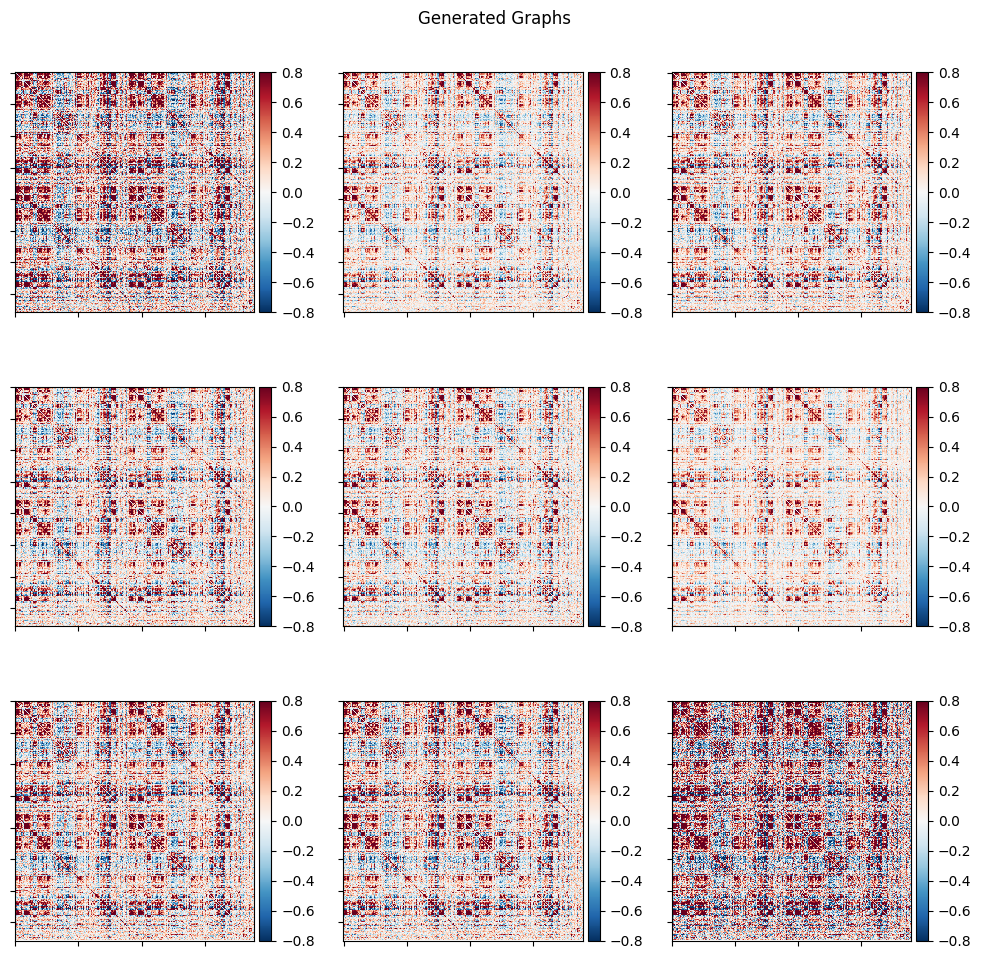

In [15]:
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()
graphs = generate_multiple_graphs(gatvae2, n_rows*n_cols, latent_dim, device=device)

for i in range(n_rows*n_cols):
  ax = axes[i]
  plot_matrix(graphs[i], colorbar=True, vmin=-0.8, vmax=0.8, axes=ax)

plt.suptitle("Generated Graphs")
plt.tight_layout()
plt.show()

In [12]:
gatvae2.eval()

GATVAE2(
  (gat1): GATConv(379, 256, heads=4)
  (gat2): GATConv(1024, 256, heads=1)
  (fc_mu): Linear(in_features=256, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=143641, bias=True)
)

In [13]:
gatvae2.eval()
all_mu = []
all_age = []
all_moca = []
all_ravlt = []
all_psqi = []

with torch.no_grad():
  for batch in train_loader:
    batch = batch.to(device='cuda' if torch.cuda.is_available() else 'cpu')
    batch.x = batch.x.float()
    mu, _ = gatvae2.encode(batch.x, batch.edge_index, batch.batch)
    graph_mu = global_mean_pool(mu, batch.batch)
    all_mu.append(graph_mu.cpu())
    labels_age = batch.age.cpu()
    labels_moca = batch.moca.cpu()
    labels_ravlt = batch.ravlt.cpu()
    labels_psqi = batch.psqi.cpu()

    all_age.append(labels_age)
    all_moca.append(labels_moca)
    all_ravlt.append(labels_ravlt)
    all_psqi.append(labels_psqi)

latent = torch.cat(all_mu, dim=0)
latent_2d = PCA(n_components=2).fit_transform(latent.numpy())

# plt.figure(figsize=(8, 6))
# plt.scatter(latent_2d[:,0], latent_2d[:,1], c=all_age, cmap='hsv', s=10)
# plt.colorbar()
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.title("VAE Latent Space Visualization (Age)")
# plt.show()

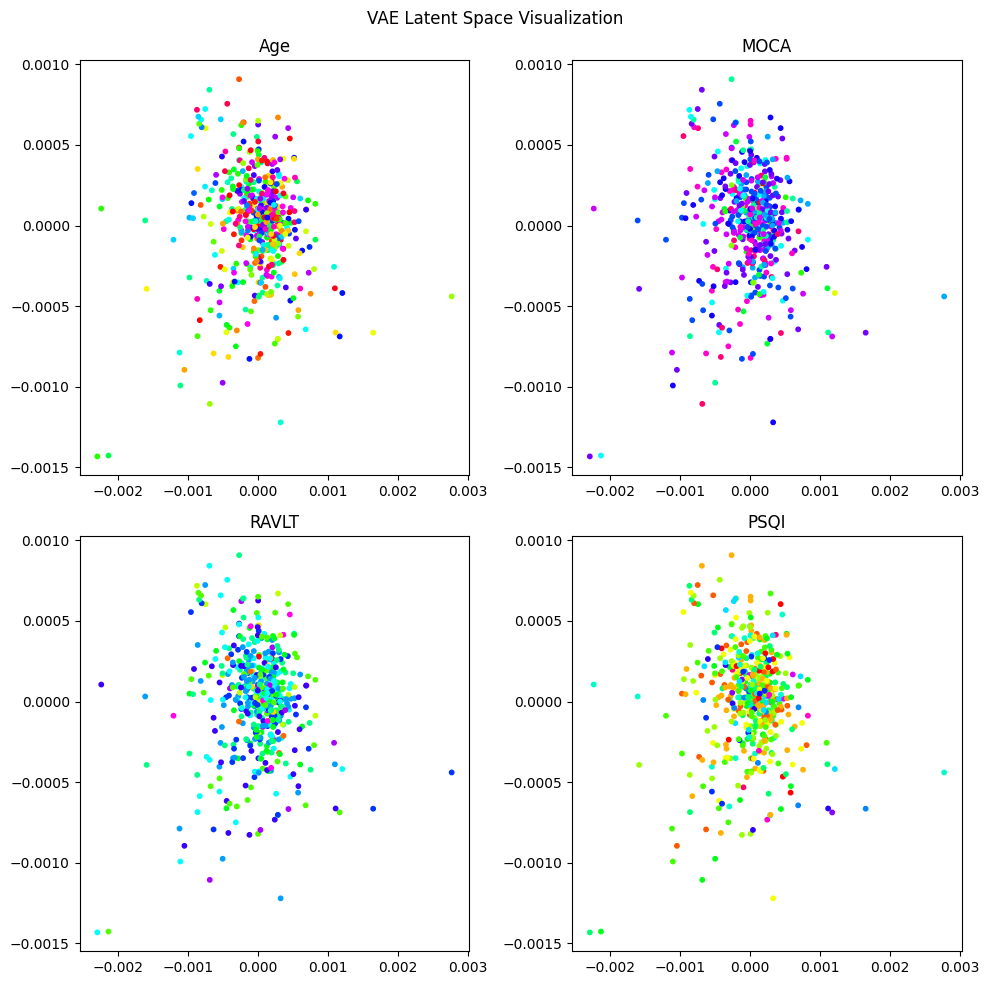

In [14]:
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

all_labels = [[all_age], [all_moca], [all_ravlt], [all_psqi]]
titles = ["Age", "MOCA", "RAVLT", "PSQI"]
axes = axes.flatten()

for i in range(n_rows*n_cols):
  ax = axes[i]
  ax.scatter(latent_2d[:,0], latent_2d[:,1], c=all_labels[i], cmap='hsv', s=10)
  ax.set_title(titles[i])

plt.suptitle("VAE Latent Space Visualization")
plt.tight_layout()
plt.show()

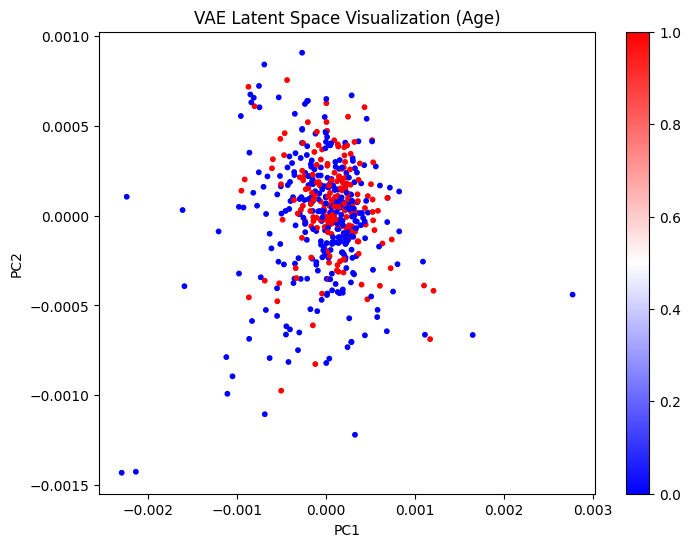

In [26]:
bin_age = (torch.cat(all_age).float() > 67.5).int()
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=bin_age, cmap='bwr', s=10)
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("VAE Latent Space Visualization (Age)")
plt.show()

In [ ]:
# gatvae_2.eval()
# all_attn_mat = {}

# with torch.no_grad():
#   for batch in train_loader:
#     _, (edge_index, attn_weights) = gatvae_2.gat1(batch.x, batch.edge_index, return_attention_weights=True)

#     attn_mean = attn_weights.mean(dim=1).cpu().numpy()
#     batch_graph_ptr = batch.ptr.cpu().numpy()
#     edge_index_np = edge_index.cpu().numpy()
#     ...